In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import albumentations as A
import argparse
import time
import tensorflow_addons as tfa

/Users/aashishkumar/.local/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:68: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.3.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.5.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [2]:
class MultiDigitDataLoaderRealData(tf.keras.utils.Sequence):
    def __init__(self, 
                 df_path, 
                 image_base_path, 
                 transform,
                 shuffle=True):
        '''
        df_path: path for dataframe which has file_name and labels
        image_base_path: folder where images are
        batch_size: batch_size while training
        img_height: height of image
        img_width: width of image
        num_time_steps = number of input time steps for lstm layer
        '''
        self.image_base_path = image_base_path
        self.shuffle = shuffle
        self.transform = transform
        
        self.char_to_int_map = {'0':0,'1':1,'2':2,'3':3,'4':4,'5':5,'6':6,'7':7,'8':8,'9':9,'a':10}
        
        self.df = pd.read_csv(df_path, header = None, dtype={0: str, 1: str})
        self.df.columns = ["file_name", "labels"]
        self.df['label_length'] = self.df['labels'].apply(self.get_label_length)
        
        ## shuffle the df
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def get_label_length(self, label):
        return len(label)
    
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return len(self.df)
    
    def get_image(self, filename):
        img = cv2.imread(filename, 0)
        img = self.transform(image=img)["image"]
        img_height = img.shape[0]
        img_width = img.shape[1]
        img = img.reshape((img_height, img_width, 1))
        return img
    
    def __getitem__(self, idx):        
        x_train = [self.get_image(self.image_base_path + self.df['file_name'][idx])]
        x_train = np.array(x_train)
        x_train = np.transpose(x_train, axes=[0,2,1,3])
        
        input_length_arr =  (x_train.shape[1] // 4) * np.ones(shape=(1, 1), dtype="int64")
        
        label_length_arr = self.df['label_length'][idx].reshape(1 ,1)
        
        y_train = np.ones([1,self.df['label_length'][idx]]) * (-1)
        # num_list = [int(char) for char in self.df['labels'][idx]]
        num_list = [self.char_to_int_map[char] for char in self.df['labels'][idx]]
        y_train[0, 0:self.df['label_length'][idx]] = num_list
        
        inputs = {'image': x_train,
                  'label': y_train,
                  'input_length': input_length_arr,
                  'label_length': label_length_arr,
                  }
        
        return inputs

In [3]:
train_df_path = "/Users/aashishkumar/Documents/Projects/forked_repos/multi-mnist/real_data_hw/set-2/train/labels.csv"
train_image_base_path = "/Users/aashishkumar/Documents/Projects/forked_repos/multi-mnist/real_data_hw/set-2/train/all/"

test_df_path = "/Users/aashishkumar/Documents/Projects/forked_repos/multi-mnist/real_data_hw/set-2/test/labels.csv"
test_image_base_path = "/Users/aashishkumar/Documents/Projects/forked_repos/multi-mnist/real_data_hw/set-2/test/all/"

shuffle = True

In [4]:
train_transform = A.Compose([
                                A.RandomBrightnessContrast(brightness_limit=0.2,contrast_limit=0.1, p=1),
                                A.ShiftScaleRotate(shift_limit_x=0.01, shift_limit_y=0.1, rotate_limit=5),
                                A.ToFloat(max_value=255)
                            ])

test_transform = A.Compose([
                                A.ToFloat(max_value=255)
                            ])


train_multi_digit_dataset = MultiDigitDataLoaderRealData(df_path = train_df_path,
                                                         image_base_path = train_image_base_path,
                                                         transform = train_transform,
                                                         shuffle = shuffle) 

test_multi_digit_dataset = MultiDigitDataLoaderRealData(df_path = test_df_path,
                                                        image_base_path = test_image_base_path,
                                                        transform = test_transform,
                                                        shuffle = shuffle) 

In [5]:
def check_dataset(data):
    for batch in data:
        print("x_train.shape",batch['image'].shape)
        print("y_train.shape",batch['label'].shape)
        print("input_length_arr.shape",batch['input_length'].shape)
        print("label_length_arr.shape",batch['label_length'].shape)
        break

In [6]:
check_dataset(train_multi_digit_dataset)

x_train.shape (1, 19, 28, 1)
y_train.shape (1, 1)
input_length_arr.shape (1, 1)
label_length_arr.shape (1, 1)


In [7]:
check_dataset(test_multi_digit_dataset)

x_train.shape (1, 41, 28, 1)
y_train.shape (1, 3)
input_length_arr.shape (1, 1)
label_length_arr.shape (1, 1)


In [8]:
for batch in train_multi_digit_dataset:
    break

In [9]:
batch['image'].shape

(1, 19, 28, 1)

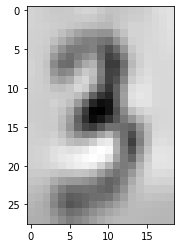

In [11]:
plt.imshow(np.transpose(batch['image'].reshape((19,28))), cmap='gray')

In [12]:
batch['label']

array([[3.]])

In [13]:
model_path = "/Users/aashishkumar/Documents/Projects/forked_repos/multi-mnist/final_models/models/comma_try2/multi_digit_model_1_to_8_comma_original"
model = tf.keras.models.load_model(model_path)
print(model.summary())


Model: "ocr_model_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, None, 28, 1) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, None, 28, 32) 320         image[0][0]                      
__________________________________________________________________________________________________
elu1 (ELU)                      (None, None, 28, 32) 0           Conv1[0][0]                      
__________________________________________________________________________________________________
Conv2 (Conv2D)                  (None, None, 28, 32) 9248        elu1[0][0]                       
_______________________________________________________________________________________

In [14]:
opt = keras.optimizers.Adam(learning_rate=0.0001)
stochastic_avg_opt = tfa.optimizers.SWA(opt)
model.compile(optimizer=stochastic_avg_opt)

In [15]:
epochs = 5
lrr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=2,verbose=1,factor=0.5, min_lr=0.000001)

# Train the model
history_1 = model.fit(
                    train_multi_digit_dataset, 
                    validation_data=test_multi_digit_dataset,
                    epochs=epochs, 
                    callbacks=[lrr]
                    )

Epoch 1/5
1121/1121 [==============================] - 26s 18ms/step - loss: 0.7597 - val_loss: 0.1348
Epoch 2/5
1121/1121 [==============================] - 19s 17ms/step - loss: 0.5070 - val_loss: 0.1060
Epoch 3/5
1121/1121 [==============================] - 19s 17ms/step - loss: 0.4255 - val_loss: 0.0941
Epoch 4/5
1121/1121 [==============================] - 18s 16ms/step - loss: 0.3617 - val_loss: 0.0920
Epoch 5/5
1121/1121 [==============================] - 19s 17ms/step - loss: 0.2749 - val_loss: 0.1083


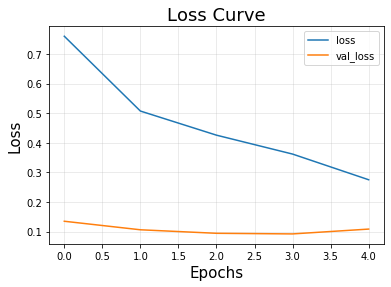

In [16]:
plt.plot(history_1.epoch,history_1.history['loss'],label="loss") # Loss curve for training set
plt.plot(history_1.epoch,history_1.history['val_loss'],label="val_loss") # Loss curve for validation set
plt.title("Loss Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Loss",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

In [17]:
prediction_model = keras.models.Model(
        model.get_layer(name="image").input, model.get_layer(name="dense2").output
    )

In [18]:
prediction_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, None, 28, 1)]     0         
_________________________________________________________________
Conv1 (Conv2D)               (None, None, 28, 32)      320       
_________________________________________________________________
elu1 (ELU)                   (None, None, 28, 32)      0         
_________________________________________________________________
Conv2 (Conv2D)               (None, None, 28, 32)      9248      
_________________________________________________________________
elu2 (ELU)                   (None, None, 28, 32)      0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, None, 14, 32)      0         
_________________________________________________________________
dropout1 (Dropout)           (None, None, 14, 32)      0     

In [19]:
def decode_batch_predictions(pred):
    char_to_int_map = {'0':0,'1':1,'2':2,'3':3,'4':4,'5':5,'6':6,'7':7,'8':8,'9':9,'a':10}
    inv_map = {v: k for k, v in char_to_int_map.items()}
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    results = results.numpy()
    # Iterate over the results and get back the text
    output_preds = []
    for res in results:
        pred_str = ""
        for i in res:
            if i != -1:
                pred_str += inv_map[i]
                # pred_str += str(i)
        output_preds.append(pred_str)
    return output_preds

In [20]:
def get_preds(dataset, model_test):
    pred_texts = []
    for i, batch in enumerate(dataset):
        if i%1000==0:
            print(i)
        batch_images = batch["image"]
        preds = model_test.predict(batch_images)
        pred_texts_temp = decode_batch_predictions(preds)
        pred_texts += pred_texts_temp
    return pred_texts

In [21]:
def editDistDP(str1, str2): 
    m = len(str1)
    n = len(str2)
    # Create a table to store results of subproblems 
    dp = [[0 for x in range(n + 1)] for x in range(m + 1)] 
  
    # Fill d[][] in bottom up manner 
    for i in range(m + 1): 
        for j in range(n + 1): 
  
            # If first string is empty, only option is to 
            # insert all characters of second string 
            if i == 0: 
                dp[i][j] = j    # Min. operations = j 
  
            # If second string is empty, only option is to 
            # remove all characters of second string 
            elif j == 0: 
                dp[i][j] = i    # Min. operations = i 
  
            # If last characters are same, ignore last char 
            # and recur for remaining string 
            elif str1[i-1] == str2[j-1]: 
                dp[i][j] = dp[i-1][j-1] 
  
            # If last character are different, consider all 
            # possibilities and find minimum 
            else: 
                dp[i][j] = 1 + min(dp[i][j-1],        # Insert 
                                   dp[i-1][j],        # Remove 
                                   dp[i-1][j-1])    # Replace 
  
    return dp[m][n] 

def get_edit_distance_freq(df):
    edit_distance_freq = {}
    wrong_count = 0
    for i in range(0, df.shape[0]):
        if df['labels'][i] is not None:
            edit_distance = editDistDP(df['labels'][i], df['preds'][i])
            if edit_distance_freq.get(edit_distance) is None:
                edit_distance_freq[edit_distance] = 1
            else:
                edit_distance_freq[edit_distance] += 1
            if edit_distance > 2:
                print(df['file_name'][i],df['labels'][i], df['preds'][i], i)
            if df['labels'][i] != df['preds'][i]:
                wrong_count += 1
    
    return edit_distance_freq, wrong_count

def show_edit_distance_freq_graph(edit_distance_freq, title, figure_folder=None):
    plt.figure(figsize=(7,5))
    plt.bar(edit_distance_freq.keys(),edit_distance_freq.values(),width = 0.8,color="orange")
    for i in edit_distance_freq:
        plt.text(i,edit_distance_freq[i],str(edit_distance_freq[i]),horizontalalignment='center',fontsize=10)

    plt.tick_params(labelsize = 14)
    plt.xticks(range(0,8))
    plt.xlabel("Edit Distance",fontsize=16)
    plt.ylabel("Frequency",fontsize=16)
    plt.title(title)
    
def get_word_leng_freq(df):
    correct_word_length_freq = {}
    wrong_word_length_freq = {}
    for i in range(0, df.shape[0]):
        if df['labels'][i] == df['preds'][i]:
            word_length = len(df['labels'][i])
            if correct_word_length_freq.get(word_length) is None:
                correct_word_length_freq[word_length] = 1
            else:
                correct_word_length_freq[word_length] += 1
        else:
            word_length = len(df['labels'][i])
            if wrong_word_length_freq.get(word_length) is None:
                wrong_word_length_freq[word_length] = 1
            else:
                wrong_word_length_freq[word_length] += 1
        
    return correct_word_length_freq, wrong_word_length_freq

def show_word_length_freq_graph(freq_var, title, figure_folder=None):
    plt.figure(figsize=(7,5))
    plt.bar(freq_var.keys(),freq_var.values(),width = 0.8,color="orange")
    for i in freq_var:
        plt.text(i,freq_var[i],str(freq_var[i]),horizontalalignment='center',fontsize=10)

    plt.tick_params(labelsize = 14)
    plt.xticks(range(0,10))
    plt.xlabel("word length",fontsize=16)
    plt.ylabel("Frequency",fontsize=16)
    plt.title(title)


In [22]:
train_pred_texts = get_preds(train_multi_digit_dataset, prediction_model)
df_train_labels = train_multi_digit_dataset.df.copy()
df_train_labels['preds'] = train_pred_texts

test_pred_texts = get_preds(test_multi_digit_dataset, prediction_model)
df_test_labels = test_multi_digit_dataset.df.copy()
df_test_labels['preds'] = test_pred_texts

0
1000
0



Calculating Edit Distance

882.bmp 49 117 629

Calculating Word Length Frequency



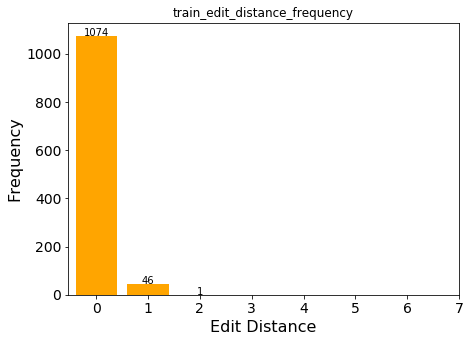

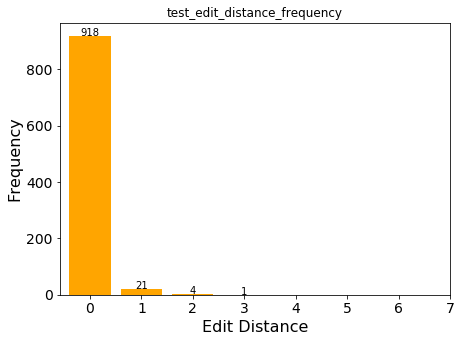

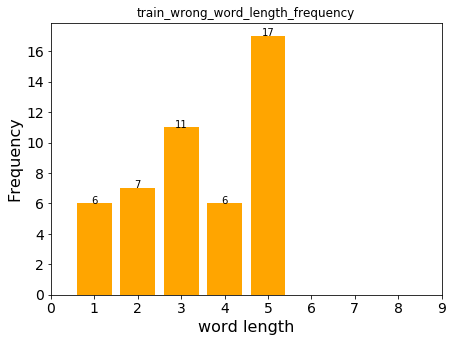

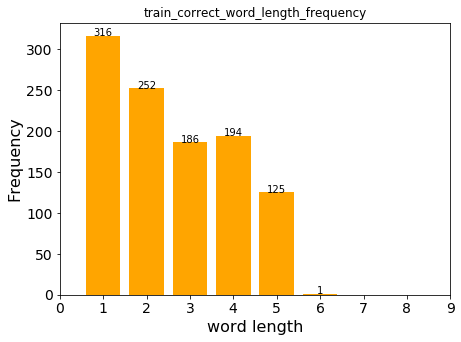

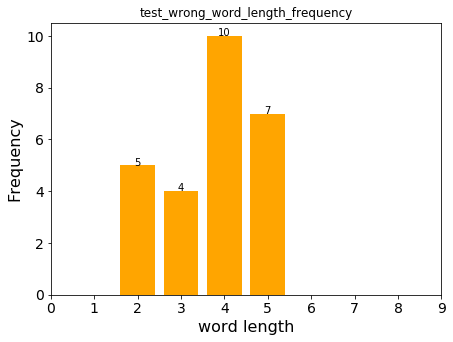

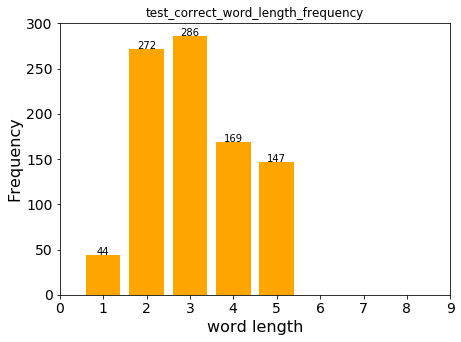

In [23]:
print("\nCalculating Edit Distance\n")
train_edit_distance_freq, train_wrong_count = get_edit_distance_freq(df_train_labels)
show_edit_distance_freq_graph(train_edit_distance_freq, "train_edit_distance_frequency")

test_edit_distance_freq, test_wrong_count = get_edit_distance_freq(df_test_labels)
show_edit_distance_freq_graph(test_edit_distance_freq, "test_edit_distance_frequency")

print("\nCalculating Word Length Frequency\n")
train_correct_word_length_freq, train_wrong_word_length_freq = get_word_leng_freq(df_train_labels)
show_word_length_freq_graph(train_wrong_word_length_freq,"train_wrong_word_length_frequency")
show_word_length_freq_graph(train_correct_word_length_freq,"train_correct_word_length_frequency")

test_correct_word_length_freq, test_wrong_word_length_freq = get_word_leng_freq(df_test_labels)
show_word_length_freq_graph(test_wrong_word_length_freq,"test_wrong_word_length_frequency")
show_word_length_freq_graph(test_correct_word_length_freq,"test_correct_word_length_frequency")

In [24]:
total_train_samples = df_train_labels.shape[0]
print("Train wrong:", train_wrong_count)
print("Train size:", total_train_samples)
print("Train Error %:",train_wrong_count/total_train_samples*100)
print("Train Accuracy %:",(1 - (train_wrong_count/total_train_samples))*100)

total_test_samples = df_test_labels.shape[0]
print("Test wrong:", test_wrong_count)
print("Test size:", total_test_samples)
print("Test Error %:",test_wrong_count/total_test_samples*100)
print("Test Accuracy %:",(1 - (test_wrong_count/total_test_samples))*100)

Train wrong: 47
Train size: 1121
Train Error %: 4.192685102586976
Train Accuracy %: 95.80731489741302
Test wrong: 26
Test size: 944
Test Error %: 2.754237288135593
Test Accuracy %: 97.2457627118644


0
1000
0

Calculating Edit Distance

985.bmp 76 180 44
43.bmp 900 4113 164
131.bmp 829 1421 345
882.bmp 49 117 629

Calculating Word Length Frequency



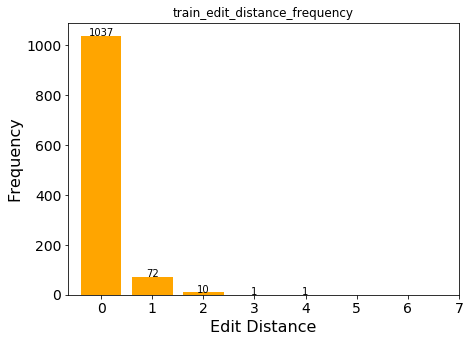

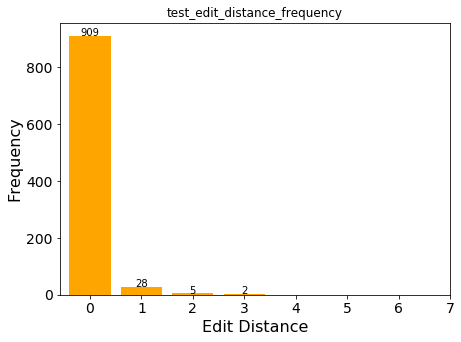

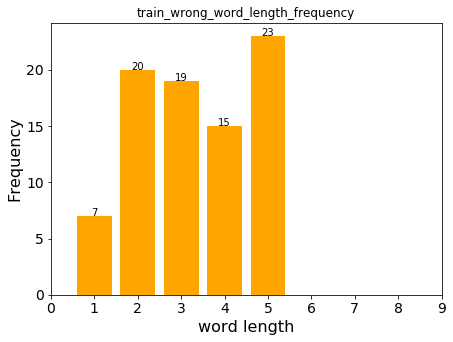

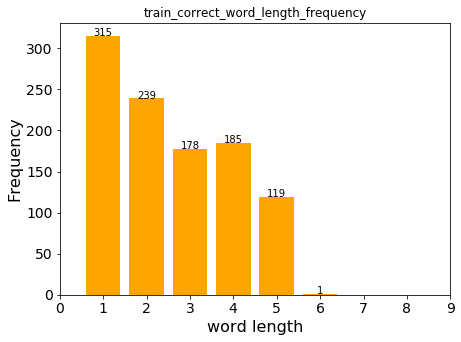

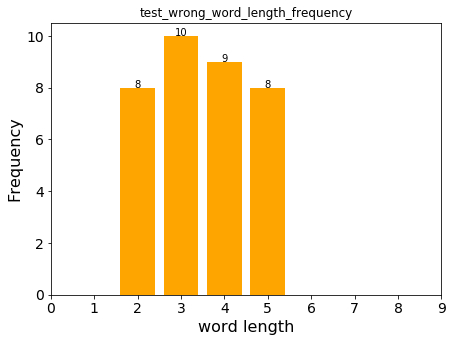

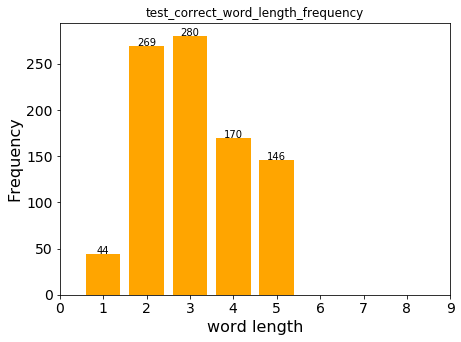

In [25]:
# old_pred_model_path = "/Users/aashishkumar/Documents/Projects/forked_repos/multi-mnist/final_models/models/comma_try2/multi_digit_model_1_to_8_comma"
old_pred_model_path = "/Users/aashishkumar/Documents/Projects/forked_repos/multi-mnist/real_data_ocr_model/comma_try2_retrain/multi_digit_model_1_to_8_comma"
old_pred_model = tf.keras.models.load_model(old_pred_model_path)

train_pred_texts = get_preds(train_multi_digit_dataset, old_pred_model)
df_train_labels_1 = train_multi_digit_dataset.df.copy()
df_train_labels_1['preds'] = train_pred_texts

test_pred_texts = get_preds(test_multi_digit_dataset, old_pred_model)
df_test_labels_1 = test_multi_digit_dataset.df.copy()
df_test_labels_1['preds'] = test_pred_texts

print("\nCalculating Edit Distance\n")
train_edit_distance_freq, train_wrong_count = get_edit_distance_freq(df_train_labels_1)
show_edit_distance_freq_graph(train_edit_distance_freq, "train_edit_distance_frequency")

test_edit_distance_freq, test_wrong_count = get_edit_distance_freq(df_test_labels_1)
show_edit_distance_freq_graph(test_edit_distance_freq, "test_edit_distance_frequency")

print("\nCalculating Word Length Frequency\n")
train_correct_word_length_freq, train_wrong_word_length_freq = get_word_leng_freq(df_train_labels_1)
show_word_length_freq_graph(train_wrong_word_length_freq,"train_wrong_word_length_frequency")
show_word_length_freq_graph(train_correct_word_length_freq,"train_correct_word_length_frequency")

test_correct_word_length_freq, test_wrong_word_length_freq = get_word_leng_freq(df_test_labels_1)
show_word_length_freq_graph(test_wrong_word_length_freq,"test_wrong_word_length_frequency")
show_word_length_freq_graph(test_correct_word_length_freq,"test_correct_word_length_frequency")

In [26]:
total_train_samples = df_train_labels_1.shape[0]
print("Train wrong:", train_wrong_count)
print("Train size:", total_train_samples)
print("Train Error %:",train_wrong_count/total_train_samples*100)
print("Train Accuracy %:",(1 - (train_wrong_count/total_train_samples))*100)

total_test_samples = df_test_labels_1.shape[0]
print("Test wrong:", test_wrong_count)
print("Test size:", total_test_samples)
print("Test Error %:",test_wrong_count/total_test_samples*100)
print("Test Accuracy %:",(1 - (test_wrong_count/total_test_samples))*100)

Train wrong: 84
Train size: 1121
Train Error %: 7.493309545049064
Train Accuracy %: 92.50669045495094
Test wrong: 35
Test size: 944
Test Error %: 3.7076271186440675
Test Accuracy %: 96.29237288135593


In [27]:
output_dir_prefix = "/Users/aashishkumar/Documents/Projects/forked_repos/multi-mnist/real_data_ocr_model/comma_try2_preprocess_retrain"
model_folder_name = "multi_digit_model_1_to_8_comma"
model_json_file_name = "multi_digit_model_1_to_8_comma_json.json"
model_weights_file_name =  "multi_digit_model_1_to_8_comma_weights.h5"
model_tflite_name = "worksheet.multi_digit_model_1_to_8_comma_try2_preprocess_retrain.tflite"

if not os.path.isdir(output_dir_prefix):
    os.mkdir(output_dir_prefix)


print("\n\nSaving Original Model\n\n")
model.save(output_dir_prefix + "/" + model_folder_name + "_original")
    
print("\n\nSaving Prediction Model\n\n")
prediction_model.save(output_dir_prefix + "/" + model_folder_name)

model_json = prediction_model.to_json()
with open(output_dir_prefix + "/" + model_json_file_name, "w") as json_file:
    json_file.write(model_json)

prediction_model.save_weights(output_dir_prefix + "/" + model_weights_file_name)

# convert to tflite model
print("\n\nConverting to TF Lite \n\n")
converter = tf.lite.TFLiteConverter.from_keras_model(prediction_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()

with tf.io.gfile.GFile(output_dir_prefix + "/" + model_tflite_name, 'wb') as f:
    f.write(tflite_model)





Saving Original Model




INFO:tensorflow:Assets written to: /Users/aashishkumar/Documents/Projects/forked_repos/multi-mnist/real_data_ocr_model/comma_try2_preprocess_retrain/multi_digit_model_1_to_8_comma_original/assets


INFO:tensorflow:Assets written to: /Users/aashishkumar/Documents/Projects/forked_repos/multi-mnist/real_data_ocr_model/comma_try2_preprocess_retrain/multi_digit_model_1_to_8_comma_original/assets




Saving Prediction Model




INFO:tensorflow:Assets written to: /Users/aashishkumar/Documents/Projects/forked_repos/multi-mnist/real_data_ocr_model/comma_try2_preprocess_retrain/multi_digit_model_1_to_8_comma/assets


INFO:tensorflow:Assets written to: /Users/aashishkumar/Documents/Projects/forked_repos/multi-mnist/real_data_ocr_model/comma_try2_preprocess_retrain/multi_digit_model_1_to_8_comma/assets




Converting to TF Lite 




INFO:tensorflow:Assets written to: /var/folders/37/87g3892x21x024jdl2nzr1_00000gp/T/tmps3vl5fd3/assets


INFO:tensorflow:Assets written to: /var/folders/37/87g3892x21x024jdl2nzr1_00000gp/T/tmps3vl5fd3/assets


In [ ]:
# print("\n\nSaving Original Model\n\n")
# model.save(output_dir_prefix + "/" + model_folder_name + "_original")